# 1.0 An end-to-end classification problem



## 1.1 Dataset description



We'll be looking at individual income in the United States. The **data** is from the **1994 census**, and contains information on an individual's **marital status**, **age**, **type of work**, and more. The **target column**, or what we want to predict, is whether individuals make less than or equal to 50k a year, or more than **50k a year**.

You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Adult).

## 1.2 Load Libraries, Train and Validation Sets

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from sklearn.tree import plot_tree
import wandb
RANDOM = 40028922

In [3]:
!wandb login --relogin

wandb: Currently logged in as: victorvieirat (mlops-victor). Use `wandb login --relogin` to force relogin


In [4]:
# save_code tracking all changes of the notebook and sync with Wandb
run = wandb.init(project="mlops-final-project")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: victorvieirat (mlops-victor). Use `wandb login --relogin` to force relogin


In [51]:
local_path = run.use_artifact("mlops-final-project/train_data.csv:latest").file()
df_train = pd.read_csv(local_path)

local_path = run.use_artifact("mlops-final-project/test_data.csv:latest").file()
df_test = pd.read_csv(local_path)

In [52]:
df_train.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,room_type,accommodates,bathrooms_text,bedrooms,...,Laranjeiras,Camorim,Leme,Catete,Santa Teresa,Jacarepaguá,Tijuca,Flamengo,Centro,Botafogo
0,-71.0,1,0.97,0.58,239.0,239.0,4,16,4.0,4.0,...,0,0,0,0,0,0,0,0,0,0
1,-131.0,1,1.00,1.00,0.0,0.0,4,4,2.0,2.0,...,0,0,0,0,0,1,0,0,0,0
2,-59.0,4,0.10,0.00,2.0,2.0,4,6,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,-91.0,2,0.96,0.81,18.0,18.0,4,5,1.5,2.0,...,0,0,0,0,0,0,0,0,0,0
4,-86.0,3,0.50,0.90,1.0,1.0,2,3,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_test.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,room_type,accommodates,bathrooms_text,bedrooms,...,Laranjeiras,Camorim,Leme,Catete,Santa Teresa,Jacarepaguá,Tijuca,Flamengo,Centro,Botafogo
0,-79.0,1,0.79,0.72,3.0,3.0,2,2,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0
1,-81.0,4,0.00,0.72,3.0,3.0,4,1,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,-74.0,4,0.00,0.72,1.0,1.0,4,6,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
3,-98.0,2,0.90,1.00,4.0,4.0,4,5,1.5,2.0,...,0,0,0,0,0,0,0,0,0,0
4,-86.0,1,1.00,0.95,8.0,8.0,4,5,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0


## 1.3 Train and Dev split

In [199]:
# split-out train/validation and test dataset
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels="price",axis=1),
                                                    df_train["price"],
                                                    test_size=0.20,
                                                    random_state=RANDOM,
                                                    shuffle=True
                                                 )

In [200]:
print("x train: {}".format(x_train.shape))
print("y train: {}".format(y_train.shape))
print("x val: {}".format(x_val.shape))
print("y val: {}".format(y_val.shape))

x train: (13747, 209)
y train: (13747,)
x val: (3437, 209)
y val: (3437,)


## Remove Outliers

In [201]:
# Verify if columns[int64] has outliers (without data leakage!!!!!!!)

# data
x = x_train.select_dtypes("int64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

print("X_train shape [original]: {}".format(x_train.shape))
print("X_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

# income with outliner
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

X_train shape [original]: (13747, 209)
X_train shape [outlier removal]: (13419, 209)


In [202]:
q1 = y_train.describe()['25%']
q3 = y_train.describe()['75%']
inter = q3 - q1
minprice = 50
maxprice = q3 + inter*1.5
y_train = y_train.loc[(y_train > minprice) & (y_train < maxprice)]
x_train = x_train.loc[x_train.index.isin(y_train.index)]
y_val = y_val.loc[(y_val > minprice) & (y_val < maxprice)]
x_val = x_val.loc[x_val.index.isin(y_val.index)]

print("x train: {}".format(x_train.shape))
print("y train: {}".format(y_train.shape))
print("x val: {}".format(x_val.shape))
print("y val: {}".format(y_val.shape))

x train: (12256, 209)
y train: (12256,)
x val: (3112, 209)
y val: (3112,)


## 1.8 Modeling & tuning

In [219]:
# create a pipeline
pipe = Pipeline([("Regressor", DecisionTreeRegressor(max_depth=7))])

# training 
pipe.fit(x_train,y_train)

# final model
predict = pipe.predict(x_val)

In [220]:
print(MAPE(y_val,predict))
print(R2(y_val,predict))
print(MAE(y_val,predict))

0.6773745876887068
0.3721458455778096
231.76812228906994


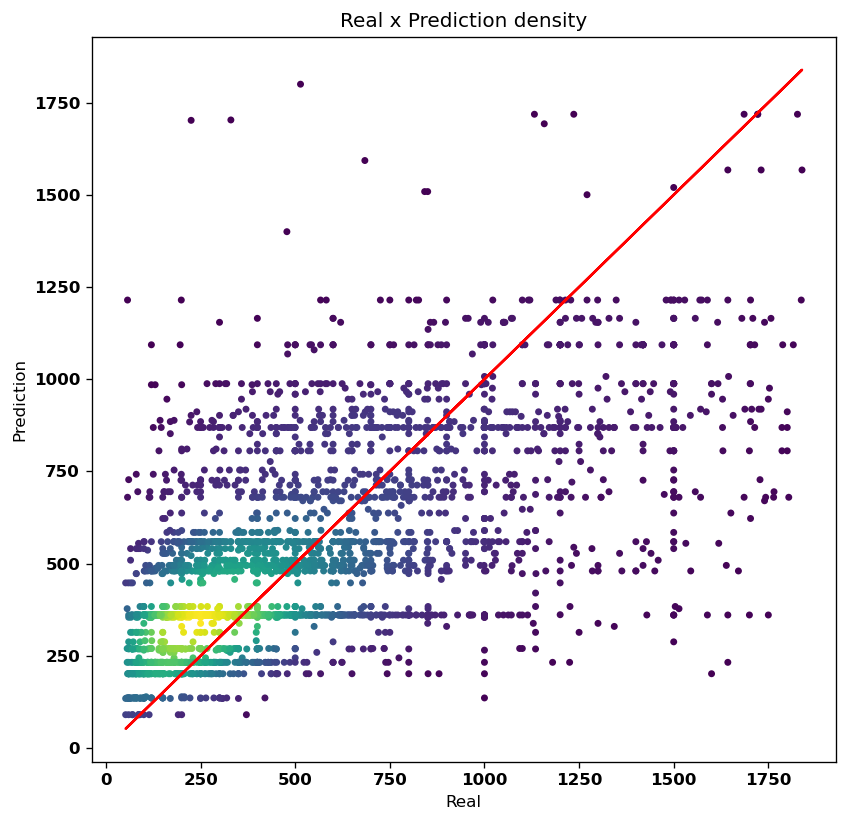

In [221]:
from scipy.stats import gaussian_kde
import numpy as np
font = {'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

# Calculate the point density
xy = np.vstack([y_val,predict])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(8, 8), dpi=120)
ax.scatter(y_val,predict, c=z, s=10)
ax.plot(y_val,y_val,color='red')
ax.set_xlabel("Real")
ax.set_ylabel("Prediction")
ax.set_title("Real x Prediction density")
plt.show()

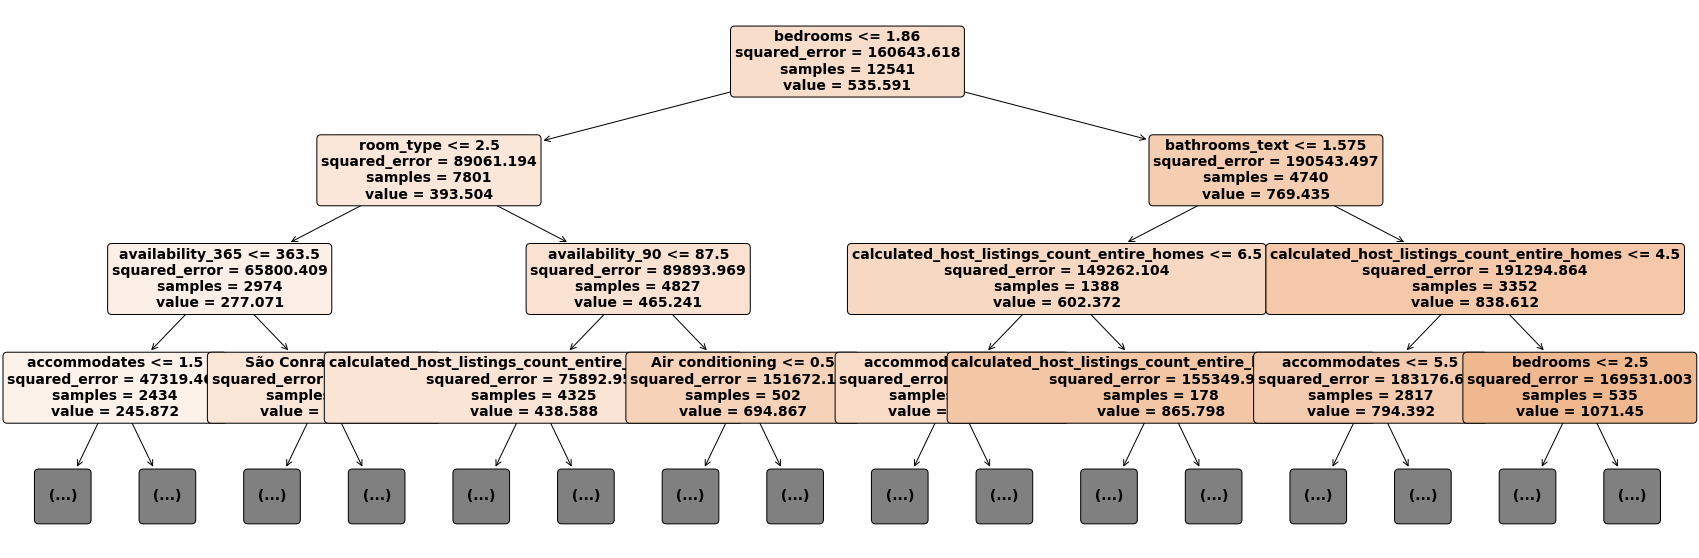

In [186]:
from sklearn.tree import plot_tree # to draw a classification tree
fig, ax = plt.subplots(1,1, figsize=(30, 10))
plot_tree(pipe["Regressor"], 
          filled=True, 
          rounded=True, 
          feature_names=x_val.columns, ax=ax,max_depth=3,fontsize=14)
plt.show()